## Markdown to check number of features based on PCA

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm

CLIP_FEATURES_DIR = "clip_features"
TRAIN = CLIP_FEATURES_DIR + "/train_features.pt"
VAL = CLIP_FEATURES_DIR + "/val_features.pt"
TOP_K_FEATURES = 250
NUM_SAMPLES = 100

In [2]:
def load_features(file_path):
    data = torch.load(file_path)
    return data["image_features"], data["text_features"], data["filenames"], data["labels"]


# Load train and validation features
train_img_features, train_txt_features, _, train_labels = load_features(TRAIN)
val_img_features, val_txt_features, _, val_labels = load_features(VAL)

In [3]:
# Combine image and text features for training
X_train = torch.cat((train_img_features, train_txt_features), dim=1)
X_val = torch.cat((val_img_features, val_txt_features), dim=1)

# Flatten features into a 2D matrix (samples x features)
X_train = X_train.view(X_train.size(0), -1).numpy()
X_val = X_val.view(X_val.size(0), -1).numpy()

# Convert labels to NumPy arrays
y_train = train_labels.numpy()
y_val = val_labels.numpy()     

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



## Train SVM

In [4]:
# Train a simple SVM model to get SHAP values
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)


SVC(kernel='linear', probability=True)

In [7]:
accuracy = accuracy_score(y_val, svm_model.predict(X_val_scaled))
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6317


In [ ]:
# Use LIME to compute feature importances over a subset of samples
explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=[f"f{i}" for i in range(X_train_scaled.shape[1])],
    class_names=[str(c) for c in np.unique(y_train)],
    mode="classification"
)

# Limit the number of samples to speed up LIME processing
sample_indices = np.random.choice(X_train_scaled.shape[0], NUM_SAMPLES, replace=False)

feature_importance = np.zeros(X_train_scaled.shape[1])

for i in tqdm(sample_indices, desc="Computing LIME Explanations"):
    exp = explainer.explain_instance(X_train_scaled[i], svm_model.predict_proba, num_features=X_train_scaled.shape[1])
    for feat_idx, weight in exp.as_map()[1]:  # class 1 explanation
        feature_importance[feat_idx] += abs(weight)

# Normalize importances
feature_importance /= NUM_SAMPLES

Computing LIME Explanations: 100%|██████████| 100/100 [24:01<00:00, 14.41s/it]


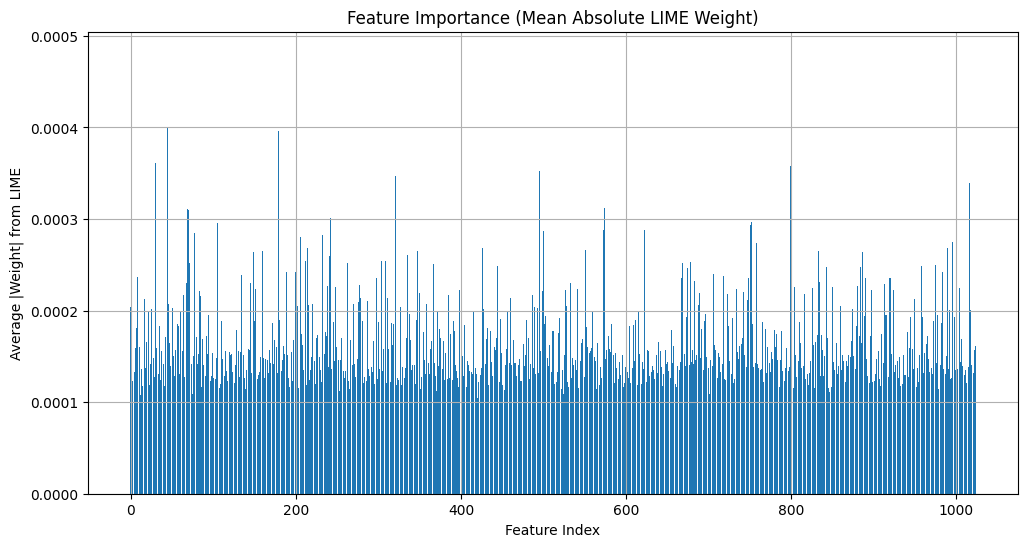

Validation Accuracy using Top 250 LIME-selected features: 0.6040


In [18]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Feature Importance (Mean Absolute LIME Weight)")
plt.xlabel("Feature Index")
plt.ylabel("Average |Weight| from LIME")
plt.grid(True)
plt.show()

# %%
# Select top-k most important features
top_k_indices = np.argsort(feature_importance)[::-1][:TOP_K_FEATURES]
X_train_lime = X_train_scaled[:, top_k_indices]
X_val_lime = X_val_scaled[:, top_k_indices]

# Save indices for later use
joblib.dump(top_k_indices, "top_k_lime_indices.joblib")

# Save the scaler
#joblib.dump(scaler, "scaler_model.joblib")

# %%
# Train SVM on selected LIME features
svm_final = SVC(kernel='linear', probability=True)
svm_final.fit(X_train_lime, y_train)

y_pred = svm_final.predict(X_val_lime)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy using Top {TOP_K_FEATURES} LIME-selected features: {accuracy:.4f}")

# Save model
#joblib.dump(svm_final, "svm_lime_model.joblib")